In [10]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [11]:
# Renaming y of the column by mapping each of the images to its output
# 0 - cavallo
# 1 - elefante
# 2 - farfalla
# 3 - gallina
# 4 - gatto

df1 = pd.read_csv('/content/cavallo.csv', header=None)
df1.rename(columns={0: 'y'}, inplace=True)
df1 = df1.assign(y=0)

df2 = pd.read_csv('/content/elefante.csv', header=None)
df2.rename(columns={0: 'y'}, inplace=True)
df2 = df2.assign(y=1)

df3 = pd.read_csv('/content/farfalla.csv', header=None)
df3.rename(columns={0: 'y'}, inplace=True)
df3 = df3.assign(y=2)

df4 = pd.read_csv('/content/gallina.csv', header=None)
df4.rename(columns={0: 'y'}, inplace=True)
df4 = df4.assign(y=3)

df5 = pd.read_csv('/content/gatto.csv', header=None)
df5.rename(columns={0: 'y'}, inplace=True)
df5 = df5.assign(y=4)

# Cleaning up the dataframe by deleting the last column
df1.drop(df1.columns[len(df1.columns)-1], axis=1, inplace=True)
df2.drop(df2.columns[len(df2.columns)-1], axis=1, inplace=True)
df3.drop(df3.columns[len(df3.columns)-1], axis=1, inplace=True)
df4.drop(df4.columns[len(df4.columns)-1], axis=1, inplace=True)
df5.drop(df5.columns[len(df5.columns)-1], axis=1, inplace=True)

frames = [df1, df2, df3, df4, df5]
df = pd.concat(frames)

In [37]:
X = df.drop(columns = ['y']).copy()
y = df['y']

X = np.array(X)
y = np.array(y)
#b = np.zeros((y.size, y.max()+1))
#b[np.arange(y.size),y] = 1

loader = DataLoader(TensorDataset(torch.tensor(X), torch.tensor(y)), batch_size = 1, shuffle = True)

In [35]:
class AANN1(nn.Module):
    def __init__(self):
        super().__init__()
          
        self.encoder = nn.Sequential(
            nn.Linear(48, 40),
            nn.Tanh(),
            nn.Linear(40, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 40),
            nn.Tanh(),
            nn.Linear(40, 48),
            #nn.Sigmoid()
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        print(encoded)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
class AANN2(nn.Module):
    def __init__(self):
        super().__init__()
          
        self.encoder = nn.Sequential(
            nn.Linear(32, 24),
            nn.Tanh(),
            nn.Linear(24, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 24),
            nn.Tanh(),
            nn.Linear(24, 32)
        )

  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
class AANN3(nn.Module):
    def __init__(self):
        super().__init__()
          
        self.encoder = nn.Sequential(
            nn.Linear(16, 12),
            nn.Tanh(),
            nn.Linear(12, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 12),
            nn.Tanh(),
            nn.Linear(12, 16)
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

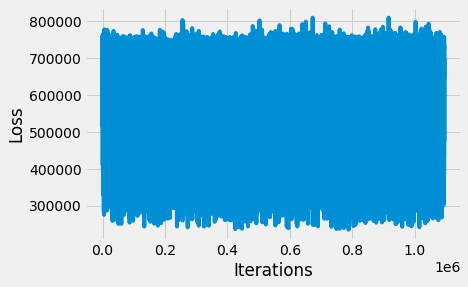

In [38]:
model = AANN1()
model.to(device)

loss_function = nn.CrossEntropyLoss()
  
optimizer = optim.Adam(model.parameters(), lr = 3e-4, weight_decay = 1e-8)

epochs = 100
losses = []
for epoch in range(epochs):
  for (histogram, _) in loader:      
    # Output of Autoencoder
    model.train()
    histogram = histogram.type(torch.float32).to(device)
    optimizer.zero_grad()

    reconstructed = model(histogram)
    # Calculating the loss function
    loss = loss_function(reconstructed, histogram)
      
    # The gradients are set to zero,
    # the the gradient is computed and stored.
    # .step() performs parameter update
    loss.backward()
    optimizer.step()
      
    # Storing the losses in a list for plotting
    losses.append(loss.detach().cpu().numpy())
  
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
  
# Plotting the last 100 values
plt.plot(losses)

In [ ]:
# Defining the batch size
BATCH_SIZE = 32

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

X_train, y_train, X_test, y_test = map(torch.tensor, [X_train, y_train, X_test, y_test])
train_dataloader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE,
                              pin_memory=True, shuffle=True)
test_dataloader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE,
                            pin_memory=True, shuffle=True)

In [ ]:
epochs = 100
accuracy_metrics = {
  'train': [],
  'test': []
}
train_loss_list = list()

for epoch in range(epochs):
    temp_loss_list = list()
    correct_classified = 0
    for x_train, y_train in train_dataloader:
        model.train()
        x_train = x_train.type(torch.float32).to(device)
        y_train = y_train.type(torch.long).to(device)
        optimizer.zero_grad()

        # Output of Autoencoder
        output = model(x_train)
        # Calculating the loss function
        loss = loss_function(output, y_train)
        loss.backward()
        optimizer.step()
        temp_loss_list.append(loss.detach().cpu().numpy())
        max_indices = torch.argmax(output, dim=1)
        correct_classified +=  (max_indices == y_train).float().sum()
          
        # Storing the losses in a list for plotting
    train_loss_list.append(np.average(temp_loss_list))
    accuracy_metrics["train"].append(correct_classified.item() / len(train_dataloader.dataset))
    print("epoch:", epoch)
    print("Train Accuracy: ", correct_classified.item() / len(train_dataloader.dataset))
  
correct_classified = 0
model.eval()
test_loss_list = list()
for X_test, y_test in test_dataloader:
    X_test = X_test.type(torch.float32).to(device)
    y_test = y_test.type(torch.long).to(device)

    score = model(X_test)
    loss = loss_function(input=score, target=y_test)

    test_loss_list.append(loss.detach().cpu().numpy())
    max_indices = torch.argmax(score, dim=1)
    correct_classified +=  (max_indices == y_test).float().sum()

accuracy_metrics["test"].append(correct_classified.item() / len(test_dataloader.dataset))
test_loss_list.append(np.average(test_loss_list))

print("Train average loss: %.5f" %train_loss_list[-1])
print("Test average loss: %.5f" %test_loss_list[-1])
print("Test Accuracy: %.5f" %accuracy_metrics['test'][0])
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
  
plt.plot(train_loss_list)



epoch: 0
Accuracy:  0.28925431083704467
epoch: 1
Accuracy:  0.3607399794450154
epoch: 2
Accuracy:  0.37124586045449354
epoch: 3
Accuracy:  0.37923946557040084
epoch: 4
Accuracy:  0.3849491835103346


KeyboardInterrupt: ignored